In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lib.models as models
from lib.core.config import config
from lib.core.config import update_config
from lib.core.integral_loss import get_joint_location_result
from lib.utils.img_utils import convert_cvimg_to_tensor

from lib.utils.vis import drawskeleton, show3Dpose


# Load config file
You can specify the pretrained models, and other configuration parameters in `*.yaml` file and update the `cfg_file` parameter accordingly

In [2]:
cfg_file = 'experiments/h36m/valid.yaml'
cfg_file = 'experiments/wormnd/train-ss.yaml'
cfg_file = r"D:\GitHub\WormID\EpipolarPose\output\wormnd\pose3d_resnet_50\test_wormnd_dataset\train-ss.yaml"
update_config(cfg_file)
config
torch.backends.cudnn.benchmark = config.CUDNN.BENCHMARK
torch.backends.cudnn.deterministic = config.CUDNN.DETERMINISTIC
torch.backends.cudnn.enabled = config.CUDNN.ENABLED

image_size = config.MODEL.IMAGE_SIZE[0]

# Create model

In [3]:
model = models.pose3d_resnet.get_pose_net(config, is_train=False)
gpus = [int(i) for i in config.GPUS.split(',')]
model = torch.nn.DataParallel(model, device_ids=gpus).cuda()
print('Created model...')


Created model...


In [4]:

# config.MODEL.RESUME = r"D:\GitHub\WormID\EpipolarPose\output\wormnd\pose3d_resnet_50\test_wormnd_dataset\final_state.pth.tar"
config.MODEL.RESUME = r"D:\GitHub\WormID\EpipolarPose\output\wormnd\pose3d_resnet_50\test_wormnd_dataset\checkpoint.pth.tar"
# "D:\GitHub\WormID\EpipolarPose\output\wormnd\pose3d_resnet_50\test_wormnd_dataset\checkpoint.pth.tar"
checkpoint = torch.load(config.MODEL.RESUME)
# model.load_state_dict(checkpoint)
model.load_state_dict(checkpoint['state_dict'])  # Access the state_dict key specifically
model.eval()
print('Loaded pretrained weights...')

Loaded pretrained weights...


# Read and prepocess a sample image

In [5]:
# img_path = 'sample_images/0.jpg'
# image = cv2.imread(img_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
# image = cv2.resize(image, (image_size, image_size))

img_path = r'D:\Data\WormID\NWB_data\data_for_epipose\20231013-13-28-0_layer_22.npy'
image = np.load(img_path)
print(image.shape)
image = cv2.resize(image, (image_size, image_size))

img_height, img_width, img_channels = image.shape
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

(229, 461, 3)


In [6]:

img_patch = convert_cvimg_to_tensor(image)

mean = np.array([123.675, 116.280, 103.530])
std = np.array([58.395, 57.120, 57.375])
    
# # apply normalization
# for n_c in range(img_channels):
#     if mean is not None and std is not None:
#         img_patch[n_c, :, :] = (img_patch[n_c, :, :] - mean[n_c]) / std[n_c]
img_patch = torch.from_numpy(img_patch).cuda()

# Inference

In [7]:
# Inference
preds_0 = model(img_patch[None, ...])
print(preds_0.shape) # n_joints, 64*64*64
print(image_size)
print(preds_0.shape[1]/64 )
preds = get_joint_location_result(image_size, image_size, preds_0)[0,:,:3]
print(preds.shape)

torch.Size([1, 12800, 64, 64])
256
200.0
(200, 3)


# Visualize results

(256, 256, 3)


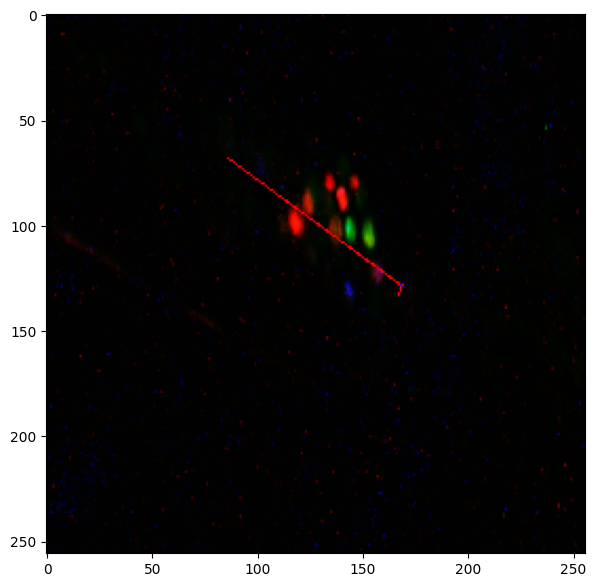

In [8]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot(111)  # Changed from '121' string to integer 121
print(image.shape)

drawskeleton(image, preds, thickness=1)
ax.imshow(image)


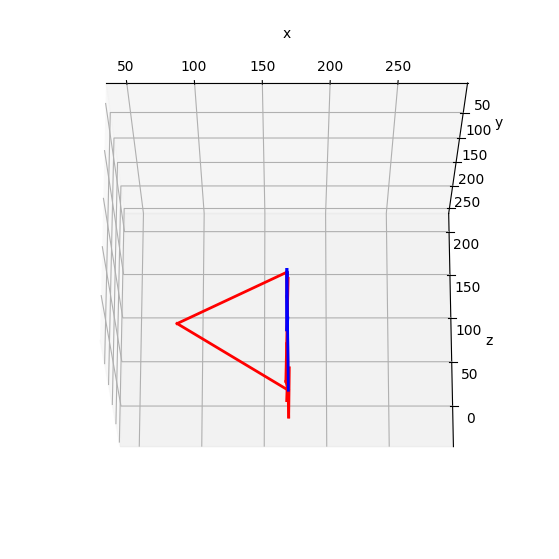

In [16]:

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d' )  
show3Dpose(preds, ax, radius=128)
ax.view_init(-75, -90)
ax.view_init(-50, -70)
ax.view_init(-20, -90)

In [17]:
print(preds_0.shape) # 1 * n_joints, 64*64*64
preds_cube = preds_0.reshape(1, -1, 64, 64, 64).detach().cpu().numpy()[0,:,:,:]
print(preds_cube.shape) #  (17, 64, 64, 64)
# # visualize preds_0




torch.Size([1, 12800, 64, 64])
(200, 64, 64, 64)


In [18]:
assert False

import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import numpy as np


    # Create figure and 3D axes
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get coordinates of points above threshold
    x, y, z = np.where(cube_data > threshold)
    
    # Create scatter plot
    scatter = ax.scatter(x, y, z, c=cube_data[x, y, z], cmap='Greens')
    
    # Add colorbar
    plt.colorbar(scatter)
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

# For your data:
joint_index = 10  # Change this to visualize different joints
visualize_3d_cube(preds_cube[joint_index])

: 

In [ ]:

# # # visualize a 3d cube of 64*64*64 

# fig = plt.figure(figsize=(12, 7))

# # Visualize the first joint's 3D cube
# joint_index = 10  # Change this to visualize other joints
# for z in range(preds_cube.shape[3]):
#     ax = fig.add_subplot(8, 8, z + 1)  # Adjust subplot grid size as needed
#     ax.imshow(preds_cube[joint_index, :, :, z], cmap='hot')
#     ax.axis('off')  # Hide axes for clarity

# plt.show()

In [39]:
# !pip install pyvista

c:\Users\jd\.conda\envs\meta\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


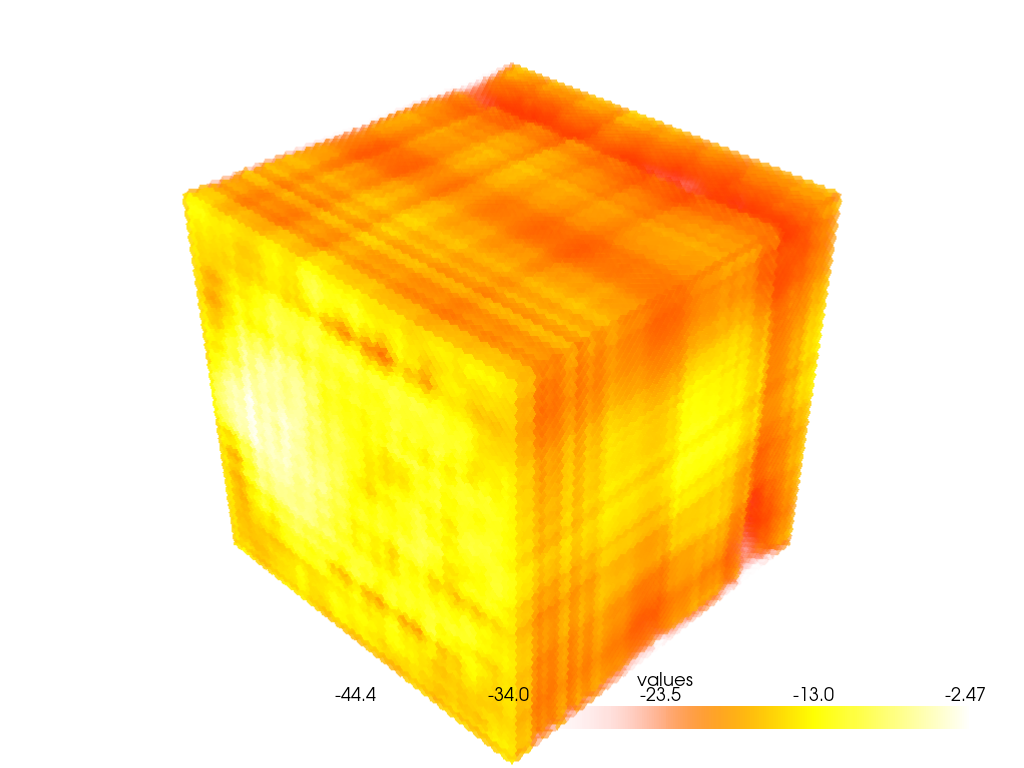

In [42]:
import pyvista as pv
import numpy as np

def visualize_3d_volume(cube_data):
    # Create a PyVista uniform grid
    grid = pv.ImageData()
    grid.dimensions = np.array(cube_data.shape) + 1
    grid.cell_data["values"] = cube_data.flatten(order="F")
    
    # Create a plotter
    plotter = pv.Plotter()
    
    # Add volume rendering
    plotter.add_volume(grid, cmap="hot", opacity="sigmoid")
    
    # Show the plot
    plotter.show()

# For your data:
joint_index = 10  # Change this to visualize different joints
visualize_3d_volume(preds_cube[joint_index])